# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"
                      }
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn    # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'

print(device)
torch.__version__

mps


'2.6.0'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning

* Excel speadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

How might we better visualize our data?

This is where the data explorer's motto come in!

"Visualize, visualize, visualize!"

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    # Are there predictions?
    if predictions is not None:
        # Plot the predictions in red if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    # Show the legend
    plt.legend(prop={'size': 14})

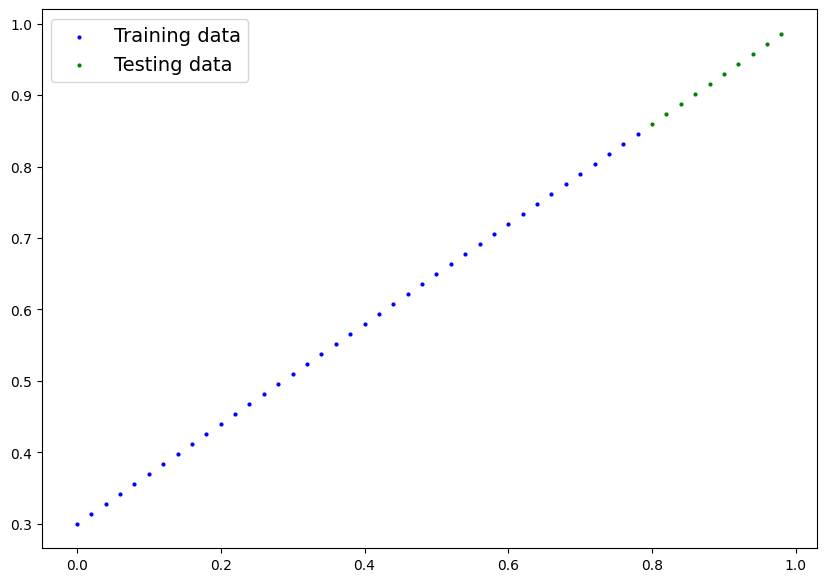

In [6]:
plot_predictions()

## 2. Build model
Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python.

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
# Create linear regression model
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,  # <- start with random weights (this will get adjusted as the model learns)
                                                requires_grad=True, # <- can we update this value with gradient descent?
                                                dtype=torch.float   # <- PyTorch loves float32 by default
                                                ))
        
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                                requires_grad=True,    # <- can we update this value with gradient descent?
                                                dtype=torch.float      # <- PyTorch loves float32 by default
                                             ))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x +b)

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered as a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model paramteters or what's inside our model using `.parameters()`

In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameters(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method.

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# Note: in older Pytorch code you might also tee torch.no_grad()
# with torch.no_grad():
#    y_preds = model_0(X_test)

In [11]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions: {len(y_preds)}")
print(f"Prediction values: {y_preds}")

Number of testing samples: 10
Number of predictions: 10
Prediction values: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


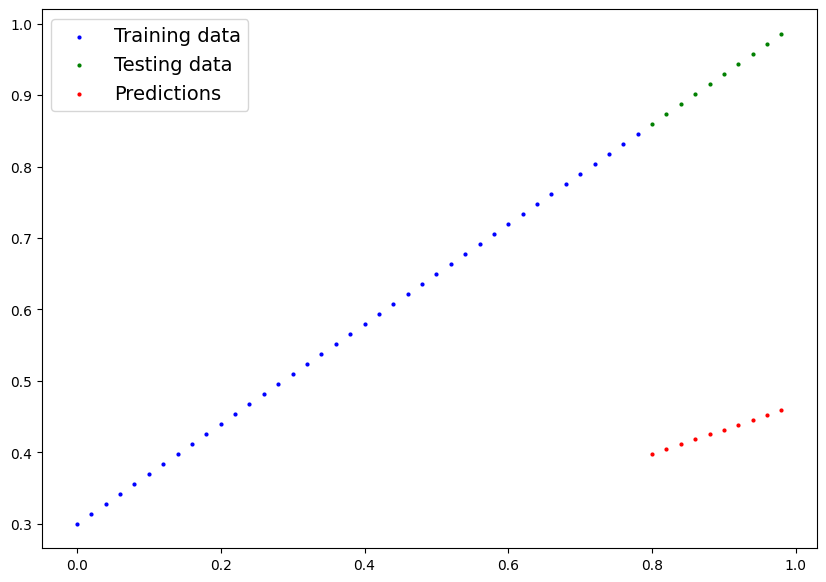

In [12]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.


And specifically for PyTorch, we need:
* A training loop
* A testing loop
    + Inside the optimizer you'll often have to set two parameters:
        - `params` - the model parameters you'd like to optimize, for example `param=model_0.parameters()`
        - `lr`(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

In [13]:
list(model_0.parameters())
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

In [14]:
# Create the loss function
loss_fn = nn.L1Loss()   # MAE loss is same as L1Loss

# Create the optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters()    # parameters of target model to optimize
                            , lr=0.01) # <- learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model tot training mode
    # Put model in training mode (this is the default state of a model)
    model_0.train() # train mode in PyTorch set sets all parameters that require gradients to require gradients

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()    # by default how the optimizer changes will accumulate through the loop, so... we have to zero them above in step 3 for each loop

    ### Testing
    # Put the model in evaluation mode
    model_0.eval()  # turns off different setting in the model not needed for evaluation/testing (like dropout/batch norm layers)
    with torch.inference_mode():    # turns off gradient tracking & a couple more things behind the scenes
    # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
        # 1. Do the forward pass on test data
        y_test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(y_test_pred, y_test.type(torch.float))  # predictions come in torch.float datatype, so comparisions need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch {epoch}: Training loss: {loss}, Testing loss: {test_loss}")

Epoch 0: Training loss: 0.31288135051727295, Testing loss: 0.48106518387794495
Epoch 10: Training loss: 0.1976713389158249, Testing loss: 0.3463551998138428
Epoch 20: Training loss: 0.08908725529909134, Testing loss: 0.2172965705394745
Epoch 30: Training loss: 0.053148530423641205, Testing loss: 0.14464019238948822
Epoch 40: Training loss: 0.04543796554207802, Testing loss: 0.11360953748226166
Epoch 50: Training loss: 0.04167863354086876, Testing loss: 0.09919948130846024
Epoch 60: Training loss: 0.03818932920694351, Testing loss: 0.08886633813381195
Epoch 70: Training loss: 0.03476089984178543, Testing loss: 0.0805937722325325
Epoch 80: Training loss: 0.03132382780313492, Testing loss: 0.07232122868299484
Epoch 90: Training loss: 0.027887403964996338, Testing loss: 0.06473556160926819


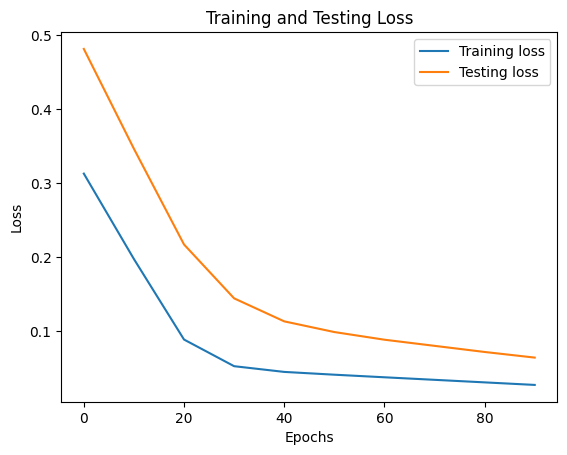

In [16]:
plt.plot(epoch_count, train_loss_values, label='Training loss')
plt.plot(epoch_count, test_loss_values, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5784]), 'bias': tensor([0.3513])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    # 3. Make sure that calculations are done with the model and data on the same device
    # in our case, we haven't setup device-agnostic code yet so our data and model are
    # on the CPU by default
    # model_0.to(device)
    # X_test = X_test.to(device)
    y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

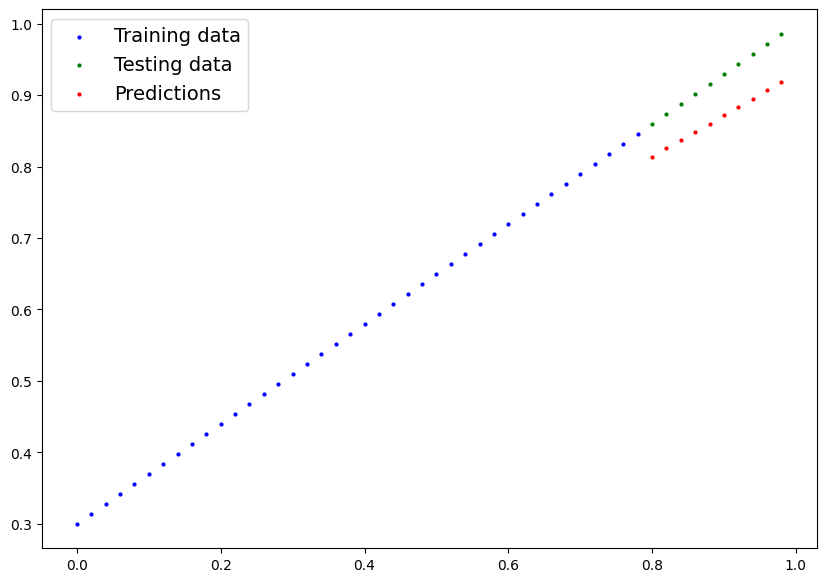

In [19]:
plot_predictions(predictions=y_preds)

## Saving a model in PyTorch
There are three main methods you should about for saving and loading models in PyTorch.
1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allos to load a model's saved stated dictionary

In [20]:
# Saving a PyTorch model's state_dict()

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) # only saving the state_dict() only saves the models learned parameters

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r--@ 1 whiteknight  staff  1680 Mar 27 16:30 models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `stated_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [22]:
# To load in a saved stated_dict we have to initiantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [24]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Set up device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
# I'm using M4 Max, so I'll use MPS, No CUDA, not cpu
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# Using cpu device

Using mps device


### 6.1 Data

In [26]:
# Create some data using the linear regression formulas of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

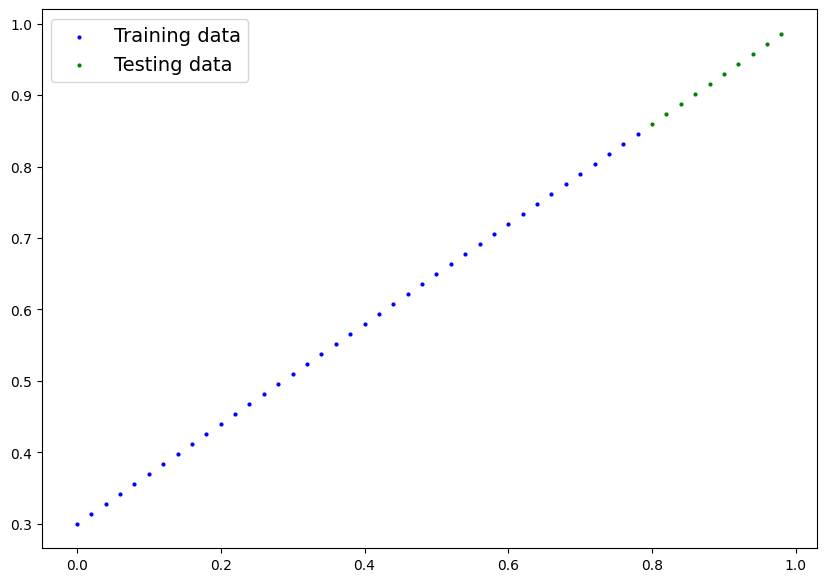

In [28]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear model

In [29]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes,
# try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [30]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [31]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [32]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='mps:0')),
             ('linear_layer.bias', tensor([0.8300], device='mps:0'))])

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [33]:
# Setup loss function
loss_fn = nn.L1Loss()   # Same as MAE loss

# Setup our optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)  # optimze newly created model's parameters

In [34]:
# Let's write a training loop
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)

    with torch.inference_mode():
        y_test_pred = model_1(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(y_test_pred, y_test)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Training loss: {loss}, Testing loss: {test_loss}")

Epoch 0: Training loss: 0.5551779270172119, Testing loss: 0.5739762783050537
Epoch 100: Training loss: 0.006215682718902826, Testing loss: 0.014086711220443249
Epoch 200: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 300: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 400: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 500: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 600: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 700: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 800: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904
Epoch 900: Training loss: 0.0012645088136196136, Testing loss: 0.013801807537674904


In [35]:
from pprint import pprint # pretty print
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 6.4 Making and evaluating predictions

In [41]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

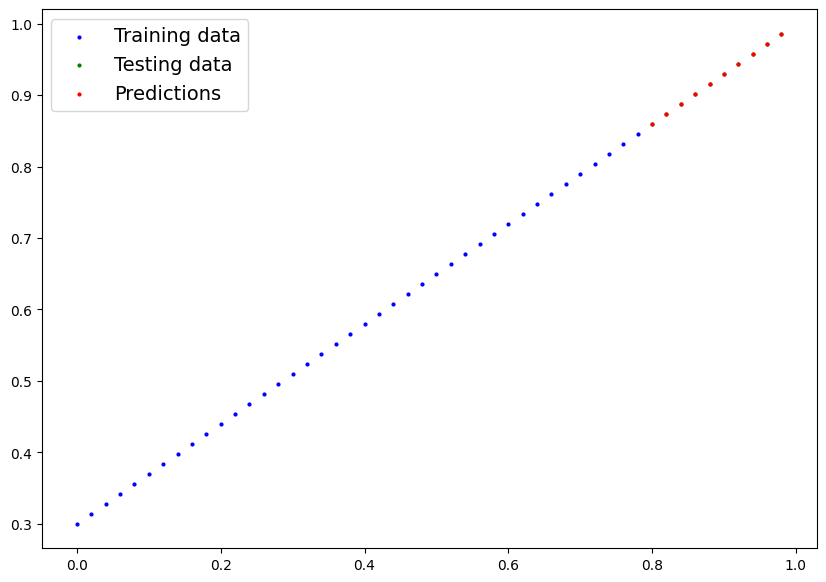

In [ ]:
# Check out our model predictions visually
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU
# NumPy is cpu based

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [38]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [44]:
# Load a PyTorch

# Create a new instance of linear regression model v2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
print(f"Model state dict:\n{loaded_model_1.state_dict()}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0
Model state dict:
OrderedDict({'linear_layer.weight': tensor([[0.6968]], device='mps:0'), 'linear_layer.bias': tensor([0.3025], device='mps:0')})


In [40]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')